# Mentoría - Tema 17 - Preparación de datos

En base al análisis exploratorio preliminar de los datos y las conversaciones con los interesados, hemos planteado un alcance para este proyecto de la siguiente manera:

### Contexto de negocio
Los datos corresponden a un sensor que mide parámetros eléctricos en la entrada de la línea a una industria que fabrica **bicicletas**. Esencialmente mide el Voltaje y la Corriente en cada fase y luego, con el desfasaje de las ondas sinodales entre esos dos, calcula todo el resto de las variables  
  
Este instrumento toma aproximadamente 5 registros por minuto que son enviados por internet a un servidor en la nube.
De vez en cuando ocurren cortes en la transmisión, el instrumento no tiene memoria interna, por lo tanto lo que no se envía al servidor, se pierde.  
  
Las industrias acuerdan un contrato con el proveedor de energía (EPEC en este caso) y, si el consumo se excede, se incurre en penalizaciones que tienen un impacto significativo en términos económicos.

#### Franjas horarias de consumo  
* Pico: 18 a 23hs.  
* Resto: 5 a 18hs.  
* Valle: 23 a 5hs.  

### Problema
Estimar si una industria va a tener penalizaciones por su consumo.

### Beneficios para el cliente  
* Puede negociar un contrato que se ajuste mejor a su consumo estimado.
* Puede planificar su producción en función de los costos y beneficios marginales. Algunos ejemplos:
  * ¿Le conviene penalizar en cierta franja horaria o dejar de producir un determinado número de productos?
  * Tal vez sea mejor contratar personal en otro turno para distribuir la producción en distintas franjas.

### Desafíos para el equipo
* Hay que trabajar en los datos para crear una nueva columna que identifique las penalizaciones, es decir, **si pasaron más de 15 minutos seguidos en los cuales el consumo eléctrico estuvo por encima de lo autorizado**.
* Los cortes en las transmisiones toman relevancia porque dentro del tiempo en el que no tenemos datos puede ocurrir una penalización. Por lo tanto, algunas cuestiones que tenemos que resolver:
  * ¿Qué tiempo de corte podemos aceptar sin necesidad de empezar a reconstruir los datos faltantes?
  * ¿Podemos aceptar los cortes en su totalidad?
* La temperatura y humedad ambiente es un dato relevante y sería bueno acoplarla al dataset. Para ellos hay que hacer un data-stitching (coser los datos) e interpolar entre cada registro de temperatura para rellenar todo el tiempo intermedio. Contamos con estos datos por parte del Servicio Meteorológico Nacional.
* Seguramente van a existir patrones de estacionalidad relacionados con diversos factores, entre ellos:
  * La temperatura y humedad ambiente a lo largo del año definitivamente tiene un efecto.
  * Los ciclos de consumo de los productos que la industria elabora. De momento desconocemos el caso de las bicicletas, pero si se tratara de una heladería o una cervecería, no es los mismo un ver y analizar datos de Julio que de Enero.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date

import seaborn as sns
sns.set_context('talk')
%matplotlib inline

In [2]:
sns.set_context("notebook", rc={"grid.linewidth": 0.6, "lines.linewidth": 1})
sns.set_style("whitegrid")
sns.set_palette("Accent_r")

In [3]:
ind_df = pd.read_csv(
    'file20201030_mes.csv')
dic_df = pd.read_csv(
    'Descripción de columnas.csv')
ind_df.shape

(226921, 63)

In [4]:
ind_df.dtypes

Active_Energy_Delivered    float64
Active_Energy_LastDay      float64
Active_Energy_Received     float64
Active_Energy_del_m_rec    float64
Active_Energy_del_p_rec    float64
                            ...   
createdAt                   object
rsrv1                        int64
rsrv2                        int64
rsrv3                        int64
rsrv4                        int64
Length: 63, dtype: object

In [5]:
# Convertimos la variable a una fecha/hora
ind_df["createdAt"] = pd.to_datetime(ind_df.createdAt)

# Ordenamos el dataframe por fecha/hora
ind_df = ind_df.sort_values("createdAt")

In [6]:
print("Primer datapoint tomado el {}".format(ind_df["createdAt"].min()))
print("Último datapoint tomado el {}".format(ind_df["createdAt"].max()))

Primer datapoint tomado el 2020-10-30 00:00:12.004000+00:00
Último datapoint tomado el 2020-11-30 23:59:59.664000+00:00


### Útiles

In [7]:
# función para formatear las etiquetas del eje X
def format_datetime_axis_ticks(axis, unit):
    if ( unit == 'H' ):
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axis.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    elif ( unit == 'D' ):
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
        axis.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    axis.tick_params(axis='x', labelrotation=45)
    

# Descarte de variables por conocimiento de dominio

Eliminamos las variables reservadas por el instrumento  
* rsrv1
* rsrv2
* rsrv3
* rsrv4  

También descartamos variables que no servirían para el propósito de este caso de estudio. Éstas, en cabio, podrían ser usadas para  saber, por ejemplo, si un generador de energía trifásico ubicado dentro de la planta tiene desbalance en las fases, lo que provocaría envejecimiento o sobrecarga de uno de las bobinas del generador.
* Voltage_L_L_Avg,
* Voltage_L_N_Avg,
* Voltage_UNB_A_B,
* Voltage_UNB_A_N,
* Voltage_UNB_B_C,
* Voltage_UNB_B_N,
* Voltage_UNB_C_A,
* Voltage_UNB_C_N,
* Voltage_UNB_L_L_Worst,
* Voltage_UNB_L_N_Worst,
* Current_UNB_A,       
* Current_UNB_B,       
* Current_UNB_C,       
* Current_UNB_Worst 


In [8]:
# Lista de variables a ser descartadas
drop_candidates = ['rsrv1', 'rsrv2', 'rsrv3', 'rsrv4',
                  'Voltage_L_L_Avg', 'Voltage_L_N_Avg', 'Voltage_UNB_A_B', 'Voltage_UNB_A_N', 
                  'Voltage_UNB_B_C', 'Voltage_UNB_B_N', 'Voltage_UNB_C_A', 'Voltage_UNB_C_N',
                  'Voltage_UNB_L_L_Worst', 'Voltage_UNB_L_N_Worst', 
                  'Current_UNB_A', 'Current_UNB_B', 'Current_UNB_C', 'Current_UNB_Worst' 
                  ]

# Análisis de datos faltantes

### Detección las variables con valor cero del dataset

In [9]:
cols = ind_df[ind_df == 0].count(axis=0)
cols[cols > 0]

Current_Avg             226921
Current_UNB_Worst       226921
Energy_Acum_Datetime    226921
Reactive_Power_Total        58
rsrv1                   226921
rsrv2                   226921
rsrv3                   226921
rsrv4                   226921
dtype: int64

* Hay 7 variables que no tienen ningún valor distinto a 0.  
* **Reactive_Power_Total** si puede asumir este valor, no consideramos que sea un error.

In [10]:
drop_candidates = drop_candidates + ['Current_Avg', 'Current_UNB_Worst', 'Energy_Acum_Datetime']

### Detección de variables con valores faltantes

In [11]:
missing_values_count = ind_df.isna().sum()
missing_values_count

Active_Energy_Delivered    0
Active_Energy_LastDay      0
Active_Energy_Received     0
Active_Energy_del_m_rec    0
Active_Energy_del_p_rec    0
                          ..
createdAt                  0
rsrv1                      0
rsrv2                      0
rsrv3                      0
rsrv4                      0
Length: 63, dtype: int64

* No hay valores nulos! Esto es por diseño.

### Variables con valores constantes

In [12]:
for col in ind_df:
    if (len(ind_df[col].unique()) == 1):
        print("{} : {} ".format(col, ind_df[col].unique()[0]))
        if (col not in drop_candidates):
            drop_candidates.append(col)

Apparent_Energy_del_p_rec : 4 
Current_Avg : 0 
Current_G : 13 
Current_UNB_A : 2 
Current_UNB_B : 1 
Current_UNB_C : 2 
Current_UNB_Worst : 0 
Energy_Acum_Datetime : 0 
Voltage_A_B : 380 
Voltage_B_C : 391 
Voltage_C_A : 383 
Voltage_L_L_Avg : 380 
Voltage_UNB_A_B : 30 
Voltage_UNB_A_N : 12 
Voltage_UNB_B_C : 23 
Voltage_UNB_B_N : 15 
Voltage_UNB_C_A : 26 
Voltage_UNB_C_N : 15 
Voltage_UNB_L_L_Worst : 12 
Voltage_UNB_L_N_Worst : 5 
rsrv1 : 0 
rsrv2 : 0 
rsrv3 : 0 
rsrv4 : 0 


* Las variables con valores constantes a lo largo de todo el dataset no aportan información, por lo tanto las descartamos también.

### Cortes de transmisión

In [13]:
# Tomamos las diferencias entre cada registro de fecha/hora (ignoramos la primera fila porque no va a tener referencia previa)

def find_data_gaps(gap_duration): # gap_duration should be passed in minutes
    deltas = ind_df["createdAt"].diff()[1:]

    # Filtramos las diferencias
    gaps = deltas[deltas > timedelta(minutes=gap_duration)]

    print('{} cortes mayores a {} minuto/s'.format(len(gaps), gap_duration))
    print('Duración promedio: {}'.format(gaps.mean()))
    print('Corte más largo: {} \n'.format(gaps.max()))

    # Creamos un dataframe con los resultados
    gaps_df = pd.DataFrame(
        ([ind_df["createdAt"][i - 1], ind_df["createdAt"][i], g / np.timedelta64(1, 'm')] for i, g in gaps.iteritems()),
        columns=['start', 'finish', 'duration']
    )
    gaps_df['time'] = pd.to_datetime(gaps_df['start'].dt.time.astype(str))
    
    return gaps_df


284 cortes mayores a 1 minuto/s
Duración promedio: 0 days 00:07:01.445204225
Corte más largo: 0 days 02:20:58.467000 

105 cortes mayores a 5 minuto/s
Duración promedio: 0 days 00:14:49.390561904
Corte más largo: 0 days 02:20:58.467000 

7 cortes mayores a 30 minuto/s
Duración promedio: 0 days 00:49:29.707428571
Corte más largo: 0 days 02:20:58.467000 



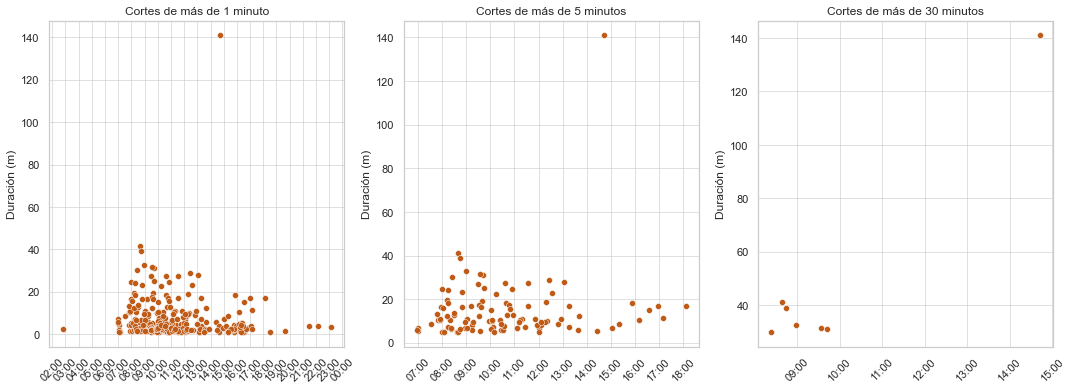

In [14]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)

axes[0] = sns.scatterplot(data=find_data_gaps(1), x="time", y="duration", ax=axes[0])
axes[0].set_title("Cortes de más de 1 minuto")
axes[0].set_xlabel("")
axes[0].set_ylabel("Duración (m)")
format_datetime_axis_ticks(axes[0], 'H')

axes[1] = sns.scatterplot(data=find_data_gaps(5), x="time", y="duration", ax=axes[1])
axes[1].set_title("Cortes de más de 5 minutos")
axes[1].set_xlabel("")
axes[1].set_ylabel("Duración (m)")
format_datetime_axis_ticks(axes[1], 'H')

axes[2] = sns.scatterplot(data=find_data_gaps(30), x="time", y="duration", ax=axes[2])
axes[2].set_title("Cortes de más de 30 minutos")
axes[2].set_xlabel("")
axes[2].set_ylabel("Duración (m)")
format_datetime_axis_ticks(axes[2], 'H')


Resumen de datos faltantes:  
* En general no hay columnas sin datos sino franjas de tiempo sin registros por cortes en la transmisión.  
* Existen más cortes por la mañana que por la tarde.  
* No se detectan cortes significativos fuera del horario comercial.  
* Sería interesante analizar si hay correlación entre los cortes y las condiciones climáticas o el consumo.  

Alternativas para tratar estos faltantes de datos:
* Dado que tenemos el consumo acumulado en la variable **"Active_Energy_Delivered"**, utilizando las ecuaciones de las leyes de Ohm ($V = I x R$) y Watt ($P = I x V$) podríamos reconstruir gran parte de las variables si suponemos que este incremento de la energía entregada por el proveedor es lineal entre el inicio y el fin del corte, además de suponer estable el Voltaje (V). De cualquier manera esto sólo valdría la pena intentarlo si a la hora de elaborar nuestro _target_ encontramos cortes significativos (más de 15 minutos) con **picos de consumo justo antes o después**.  
* Ignorar los cortes y trabajar con los datos que sí tenemos.


# Decodifiación del Factor de Potencia

El instrumento mide el factor de potencia entre los valores -2 y 2, sin embargo ese rango se divide en 4, cada uno con un valor específico que aporta nueva información.

> Se dice que el factor de potencia está en **atraso (_lagging_)** cuando el ángulo de la corriente es menor que el ángulo de la tensión. Este caso se da para cargas **inductivas**, como son los reactores y los motores de inducción.  
> Cuando el ángulo de la corriente es mayor que el ángulo de la tensión el factor de potencia está en **adelanto (_leading_)**. Este caso se da cuando las cargas tienen una alta componente **capacitiva**, como son los bancos de capacitores, generadores operando en sobre excitación y capacitores sincrónicos.

In [15]:
# Implementación del pseudo-código del datasheet del instrumento para decodificar el FP

def decode_pf(x):
    if x > 1:
        return 2 - x, -1 # FP leading -> cargas capacitivas
    elif x < -1:
        return -2 - x, -1 # FP leading -> cargas capacitivas
    elif abs(x) == 1:
        return x, 0 # FP unity -> equilibrio
    else:
        return x, 1 # FP lagging -> cargas inductivas
    

In [16]:
# Creamos nuevas columnas en nuestro dataset para cargar los valores decodificados

ind_df[['Power_Factor_A_Fixed','Power_Factor_A_Position']] = ind_df['Power_Factor_A'].apply(decode_pf).apply(pd.Series)
ind_df[['Power_Factor_B_Fixed','Power_Factor_B_Position']] = ind_df['Power_Factor_B'].apply(decode_pf).apply(pd.Series)
ind_df[['Power_Factor_C_Fixed','Power_Factor_C_Position']] = ind_df['Power_Factor_C'].apply(decode_pf).apply(pd.Series)
ind_df[['Power_Factor_Total_Fixed','Power_Factor_Total_Position']] = ind_df['Power_Factor_Total'].apply(decode_pf).apply(pd.Series)


# Eliminamos las columnas originales con el FP codificado
drop_candidates = drop_candidates + ['Power_Factor_A', 'Power_Factor_B', 'Power_Factor_C', 'Power_Factor_Total']

In [17]:
clean_df = ind_df.copy()
clean_df.shape

(226921, 71)

In [18]:
clean_df.drop(columns=drop_candidates, inplace=True)
clean_df.shape

(226921, 42)

# Valores extremos

Dado que el instrumento esencialmente mide el Voltaje y la Corriente en cada fase y luego, con el desfasaje de las ondas sinodales entre esos dos parámetros, calcula todo el resto de las variables, nos interesa particularmente saber si estas columnas del dataset tiene datos extremos.

## Voltaje

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
data_preproc = clean_df[['createdAt','Voltage_A_N','Voltage_B_N','Voltage_C_N']]
sns.lineplot(x='createdAt', y='value', hue='variable', data=pd.melt(data_preproc, ['createdAt']))


sns.lineplot(x=clean_df.createdAt, y=242, linestyle='dashed',linewidth=1,color='black', alpha=0.5)
ax.text(ind_df.createdAt.min(), 243, '+10%', fontsize=12)

sns.lineplot(x=clean_df.createdAt, y=220, linestyle='solid',linewidth=1,color='black', alpha=1)
ax.text(ind_df.createdAt.min(), 221, '220 V', fontsize=12)

sns.lineplot(x=clean_df.createdAt, y=198, linestyle='dashed',linewidth=1,color='black', alpha=0.5)
ax.text(ind_df.createdAt.min(), 199, '-10%', fontsize=12)

format_datetime_axis_ticks(ax, 'D')

plt.title('Voltaje por fase')
plt.xlabel('Tiempo')
plt.ylabel('Volts')
plt.xticks(rotation=45)
plt.show()

Se puede observar que todas las lecturas están dentro de los umbrales aceptados: **220V +- 10%**.  
A pesar de que hay un pico el día 24 de Noviembre, este puede corresponder a una bajada de tensión ocasional y, por lo tanto, no se require tratamiento posterior.

## Corriente (Amp)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
data_preproc = clean_df[['createdAt','Current_A','Current_B','Current_C']]
sns.lineplot(x='createdAt', y='value', hue='variable', data=pd.melt(data_preproc, ['createdAt']))

format_datetime_axis_ticks(ax, 'D')

plt.title('Corriente por fase')
plt.xlabel('Tiempo')
plt.ylabel('Amp')
plt.xticks(rotation=45)
plt.show()

La corriente por fase tampoco muestra valores extremos, por tanto no se realizarán tratamientos adicionales.

# Referencia: factura de EPEC

Para el periodo de tiempo comprendido en el dataset en estudio, contamos con la factura del proveedor correspondiente de la cual podemos tomar los datos de su medición para contrastar con los nuestros.  
También interesa tomar nota de la demanda autorizada (DP y DF) para poder elaborar la variable objetivo al detectar cada evento en el que se incurra en una penalización.

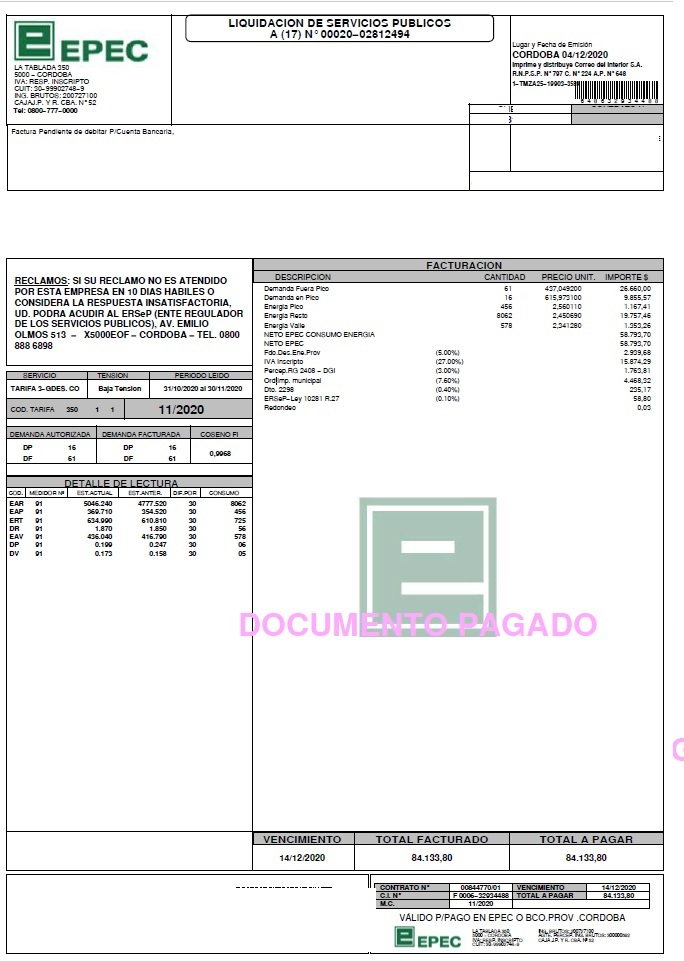

# Variable objetivo

En base al problema planteado al inicio, nuestra variable de interés dentro del dataset en estudio es **"Active_Power_Total"**, la cual mide la potencia activa total en kW y es el valor que el proveedor (EPEC) tiene en cuenta para cobrar el servicio.

In [ ]:
fig, axes = plt.subplots(figsize=(18, 8), nrows=2)

# Consumo por fase
data_preproc = clean_df[['createdAt','Active_Power_A','Active_Power_B','Active_Power_C']]
sns.lineplot(x='createdAt', y='value', hue='variable', data=pd.melt(data_preproc, ['createdAt']), ax=axes[0])
axes[0].legend(labels=["Potencia A", "Potencia B", "Potencia C"], loc="upper right")

axes[0].set_title("Potencia activa por fase")
axes[0].set_xlabel("Tiempo")
axes[0].set_ylabel("kW")
format_datetime_axis_ticks(axes[0], 'D')

# Consumo total
sns.lineplot(x=clean_df.createdAt, y=clean_df.Active_Power_Total, ax=axes[1])

# Demanda autorizada
DP_autorizada = 16 # Pico
sns.lineplot(x=clean_df.createdAt, y=DP_autorizada, linestyle='dashed', linewidth=1, color='black', ax=axes[1])
DP_autorizada_text = "DP: " + str(DP_autorizada) + " kW"
axes[1].text(clean_df.createdAt.min(), DP_autorizada, DP_autorizada_text, fontsize=16)

DF_autorizada = 61 # Fuera Pico
sns.lineplot(x=clean_df.createdAt, y=DF_autorizada, linestyle='dashed', linewidth=1, color='black', ax=axes[1])
DF_autorizada_text = "DF: " + str(DF_autorizada) + " kW"
axes[1].text(clean_df.createdAt.min(), DF_autorizada, DF_autorizada_text, fontsize=16)

axes[1].legend(labels=["Potencia Activa Total"], loc="upper right")

axes[1].set_title("Potencia activa total")
axes[1].set_xlabel("Tiempo")
axes[1].set_ylabel("kW")
format_datetime_axis_ticks(axes[1], 'D')

plt.subplots_adjust(hspace = 0.5)

### Zoom en un día - 11/11/2020

In [ ]:
mask = (clean_df['createdAt'] >= '2020-11-11 00:00') & (clean_df['createdAt'] <= '2020-11-11 23:59')

fig, axes = plt.subplots(figsize=(18, 8), nrows=2)

# Consumo por fase
data_preproc = clean_df.loc[mask][['createdAt','Active_Power_A','Active_Power_B','Active_Power_C']]
sns.lineplot(x='createdAt', y='value', hue='variable', data=pd.melt(data_preproc, ['createdAt']), ax=axes[0])
axes[0].legend(labels=["Potencia A", "Potencia B", "Potencia C"], loc="upper right")

axes[0].set_title("Potencia activa por fase")
axes[0].set_xlabel("Tiempo")
axes[0].set_ylabel("kW")
format_datetime_axis_ticks(axes[0], 'H')

# Consumo total
sns.lineplot(x=clean_df.loc[mask].createdAt, y=clean_df.loc[mask].Active_Power_Total, ax=axes[1])

# Demanda autorizada
DP_autorizada = 16 # Pico
sns.lineplot(x=clean_df.loc[mask].createdAt, y=DP_autorizada, linestyle='dashed', linewidth=1, color='black', ax=axes[1])
DP_autorizada_text = "DP: " + str(DP_autorizada) + " kW"
axes[1].text(clean_df.loc[mask].createdAt.min(), DP_autorizada, DP_autorizada_text, fontsize=16)

DF_autorizada = 61 # Fuera Pico
sns.lineplot(x=clean_df.loc[mask].createdAt, y=DF_autorizada, linestyle='dashed', linewidth=1, color='black', ax=axes[1])
DF_autorizada_text = "DF: " + str(DF_autorizada) + " kW"
axes[1].text(clean_df.loc[mask].createdAt.min(), DF_autorizada, DF_autorizada_text, fontsize=16)

axes[1].legend(labels=["Potencia Activa Total"], loc="upper right")

axes[1].set_title("Potencia activa total")
axes[1].set_xlabel("Tiempo")
axes[1].set_ylabel("kW")
format_datetime_axis_ticks(axes[1], 'H')

plt.subplots_adjust(hspace = 0.5)

Al parecer, por lo que se ve en los gráficos arriba, el cliente supera frecuentemente la demanda autorizada. Sin embargo, el fabricante advierte que existe un "factor" que deberemos tener en cuenta para que los datos del instrumento sean comparables con los de la factura.  
  
Dicho "factor" aún no conocemos por lo que la corrección necesaria no puede implementarse en este momento. Igualmente, dejaremos planteada la estrategia para elaborar la variable objetivo.  
  
**Para cada data-point compararemos el valor de lectura de la Potencia Activa Total con los umbrales de penalización en sus respectivas franjas horarias: si lo supera, rotularemos como positivo; de lo contrario, negativo. Cuando existan franjas de datos superiores a 15 minutos con todos rótulos positivos, entonces tendremos identificada una penalización.**

## Correlación de datos

In [ ]:
corr_matrix = clean_df.corr()
corr_t = corr_matrix.sort_values('Active_Power_Total').transpose()

fig = plt.figure(figsize=(20,2))
sns.heatmap(
    corr_t.loc[['Active_Power_Total'],:], 
    xticklabels=corr_t.loc[['Active_Power_Total'],:].columns.values, 
    annot=True, 
    fmt='.1g'
)


Es de esperar que por la relación matemática entre las columnas haya una alta correlación en muchas de ellas.

# Medición de temperatura

El dataset cuenta con una columna que contiene la temperatura del dispositivo en cada registro. Este datos no corresponde a las condiciones ambientales.

In [ ]:
ind_df['Temperature'].describe()

In [ ]:
temp = ind_df[["createdAt", "Temperature"]].copy()
  
# Calculamos un promedio móvil de 150 observaciones para suavizar las curvas(cada 30 min aprox)
temp['SMA30'] = temp['Temperature'].rolling(150).mean()

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
chart = sns.lineplot(x=temp['createdAt'], y=temp['SMA30'], ax=ax)
plt.legend(labels=["Temperatura ºC"], loc="upper right")
format_datetime_axis_ticks(ax, 'D')

plt.title('Variación de Temperatura')
plt.xlabel('Tiempo')
plt.ylabel('C')
plt.xticks(rotation=45)
plt.show()

# Datos meteorológicos

Creemos que sería interesante para el caso incorporar información sobre las condiciones meteorológicas ya que el consumo de energía con seguridad puede verse afectado por la temperatura y la humedad ambiente.  
  
Esta información podemos obtenerla de Servicio Meteorológico Nacional. Contamos con una dataset analizado que sabemos que puede servir al caso (ver **001_GA_EDA_SMN**). El mismo contiene data-points hora por hora de todo el rango de fechas requerido.  
  
Deberemos trabajar en alguna técnica para unir esos datos con los nuestros a través de las columnas de fecha y hora. El desafío está en que no coinciden exactamente las horas de ambos sets. Pero será trabajo para más adelante...  
  

# Conclusiones y próximos pasos

Hasta aquí hicimos una primera iteración en la exploración y análisis de los datos y el conocimiento del dominio. Entendemos que no es suficiente aún para comenzar con la elaboración de modelos ya que los datos todavía requiren tratamiento.  
  
Algunos aspectos que todavía no fueron considerados  
* Escalamiento y Normalización: si bien casi todos nuestros datos tienen escalas similares, posiblemente debamos transformarlos antes de avanzar.  
* Reconstrucción de los cortes: es necesario definir cuándo un corte en la transmisión puede afectar el objetivo perseguido y, en base a eso, definir una estrategia para reconstruirlos.  
* Determinar si los cortes tienen correlación con factores climáticos o de consumo.  
* Elaboración del target: habiendo completado los puntos anteriores, implementaremos la estrategia que se explicó más arriba. Aunque no descartamos que haya otras formas de identificar las penalización.